In [1]:
import pickle
import tensorflow as tf
import gym
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

/Users/aashishkumar/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/aashishkumar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
envname = "Hopper-v2"
filename = os.path.join('expert_data', envname + '.pkl')
print(filename)

expert_data/Hopper-v2.pkl


In [3]:
with open(filename, 'rb') as f:
    data = pickle.loads(f.read())

In [4]:
data['observations'].shape

(200000, 11)

In [5]:
data['actions'].shape

(200000, 1, 3)

In [6]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_squared_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_squared_error']),
           label = 'Val loss')
  plt.legend()
  #plt.ylim([0, 0.05])

In [8]:
train_data = data['observations']
train_labels = data['actions']
train_labels = train_labels.reshape((200000,3))

In [9]:
def build_model():
    model = Sequential()
    model.add(Dense(128,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(3))
#     model = Sequential([
#         Dense(64, activation=tf.nn.relu,
#                        input_shape=(train_data.shape[1],)),
#         Dense(64, activation=tf.nn.relu),
#         Dense(3)
#       ])

    #optimizer = tf.train.RMSPropOptimizer(0.001)
    optimizer = optimizers.Adam(lr=0.001)
    
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 9,987
Trainable params: 9,987
Non-trainable params: 0
_________________________________________________________________


In [12]:
EPOCHS = 50

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

Train on 160000 samples, validate on 40000 samples
Epoch 1/50
160000/160000 [==============================] - 5s 32us/step - loss: 2.7136e-04 - mean_squared_error: 2.7136e-04 - val_loss: 2.2724e-04 - val_mean_squared_error: 2.2724e-04
Epoch 2/50
160000/160000 [==============================] - 5s 32us/step - loss: 2.6012e-04 - mean_squared_error: 2.6012e-04 - val_loss: 2.2429e-04 - val_mean_squared_error: 2.2429e-04
Epoch 3/50
160000/160000 [==============================] - 5s 32us/step - loss: 2.5384e-04 - mean_squared_error: 2.5384e-04 - val_loss: 2.7990e-04 - val_mean_squared_error: 2.7990e-04
Epoch 4/50
160000/160000 [==============================] - 5s 32us/step - loss: 2.5832e-04 - mean_squared_error: 2.5832e-04 - val_loss: 3.8637e-04 - val_mean_squared_error: 3.8637e-04
Epoch 5/50
160000/160000 [==============================] - 5s 32us/step - loss: 2.5492e-04 - mean_squared_error: 2.5492e-04 - val_loss: 4.3002e-04 - val_mean_squared_error: 4.3002e-04
Epoch 6/50
160000/160000

Epoch 45/50
160000/160000 [==============================] - 6s 35us/step - loss: 2.0022e-04 - mean_squared_error: 2.0022e-04 - val_loss: 2.1610e-04 - val_mean_squared_error: 2.1610e-04
Epoch 46/50
160000/160000 [==============================] - 5s 33us/step - loss: 1.9628e-04 - mean_squared_error: 1.9628e-04 - val_loss: 9.8690e-05 - val_mean_squared_error: 9.8690e-05
Epoch 47/50
160000/160000 [==============================] - 5s 33us/step - loss: 1.8975e-04 - mean_squared_error: 1.8975e-04 - val_loss: 1.3383e-04 - val_mean_squared_error: 1.3383e-04
Epoch 48/50
160000/160000 [==============================] - 5s 33us/step - loss: 1.9326e-04 - mean_squared_error: 1.9326e-04 - val_loss: 1.1958e-04 - val_mean_squared_error: 1.1958e-04
Epoch 49/50
160000/160000 [==============================] - 5s 33us/step - loss: 1.8860e-04 - mean_squared_error: 1.8860e-04 - val_loss: 1.1854e-04 - val_mean_squared_error: 1.1854e-04
Epoch 50/50
160000/160000 [==============================] - 5s 33us/s

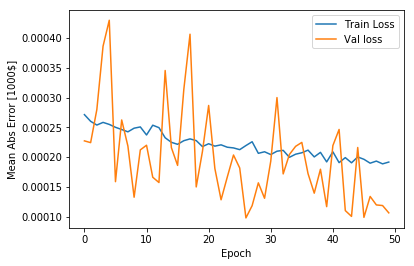

In [17]:
plot_history(history)

In [14]:
import gym
env = gym.make("Hopper-v2")
max_steps = env.spec.timestep_limit

returns = []
observations = []
actions = []
num_rollouts = 200

for i in range(num_rollouts):
    print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        obs_reshaped = obs.reshape((1,11))
        action_reshaped = model.predict(obs_reshaped)
        action = action_reshaped.reshape((3,))
        observations.append(obs)
        actions.append(action)
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
#         if args.render:
#             env.render()
        if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
        if steps >= max_steps:
            break
    returns.append(totalr)

print('returns', returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

iter 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 3
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 4
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 5
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 6
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 7
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 8
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 9
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 10
100/1000
200

900/1000
1000/1000
iter 84
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 85
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 86
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 87
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 88
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 89
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 90
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 91
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
iter 92
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 93
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 94
10

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 169
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 170
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
iter 171
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 172
100/1000
200/1000
300/1000
400/1000
iter 173
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 174
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 175
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 176
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 177
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 178
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
i

In [16]:
#print('returns', returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

mean return 3687.696719823497
std of return 314.4756930160389


In [ ]:
a = data['observations'][1]

In [ ]:
a.shape
b = a.reshape((1,11))
b.shape

In [ ]:
data['actions'][1].shape

In [ ]:
c = model.predict(b)

In [ ]:
c.shape

In [ ]:
c.reshape((3,))

In [ ]:
model.save('Hopper-v2-my-model.h5')

In [ ]:
from keras import models
new_model = models.load_model('Hopper-v2-my-model.h5')
new_model.summary()

In [ ]:
model.summary()

In [ ]:
d = c.reshape((3,))

In [ ]:
d.shape